# Valorization Entreprise Data Finpack Partie 6
Dans cette partie nous allons développer un model de prediction des valeurs d'entreprises (EV/EBITDA, EB/Sales, P/E ) basant sur finpack dataset et les classes trouvées

### **Packages** 

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow import keras
from keras import layers, regularizers, optimizers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import minmax_scale
from mpl_toolkits.mplot3d import Axes3D
import pickle

### **Data d'input**

In [2]:
#Importation les parties de description coder 
description_0_5000_coder = pd.read_excel ( 'Data Finpack V2/description_0_5000_coder.xlsx', index_col = 0 )

In [3]:
description_5000_10000_coder = pd.read_excel ( 'Data Finpack V2/description_5000_10000_coder.xlsx', index_col = 0 )

In [4]:
description_10000_15000_coder = pd.read_excel ( 'Data Finpack V2/description_10000_15000_coder.xlsx', index_col = 0 )

In [5]:
description_15000_17500_coder = pd.read_excel ( 'Data Finpack V2/description_15000_17500_coder.xlsx', index_col = 0 )

In [6]:
description_17500_21409_coder = pd.read_excel ( 'Data Finpack V2/description_17500_21409_coder.xlsx', index_col = 0 )

In [7]:
#Reconstruction de la df description
description_0_21409_coder = pd.concat( [description_0_5000_coder, description_5000_10000_coder, description_10000_15000_coder, description_15000_17500_coder, description_17500_21409_coder], axis = 0)
description_0_21409_coder

,business,products,services,summary,listed,stock,short,company's,production,engaged,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
22,1,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83681,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83687,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83690,1,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
#Importation des colonnes entreprises values
entreprise_values = pd.read_excel ( 'Data Finpack V2/Entreprise_values.xlsx', index_col = 0)
entreprise_values

,EV/EBITDA - Last,EV/EBIT - Last,P/Book Value - Last,EV/Sales - Last,P/E - Last
22,NaN,NaN,NaN,NaN,NaN
23,2.62,5.35,0.58,0.3,N/M
30,34.04,51.96,1.31,7.72,8.13
35,NaN,NaN,NaN,NaN,NaN
36,54.07,N/M,2.41,0.33,N/M
...,...,...,...,...,...
83676,5.52,6.46,0.36,1.94,10.55
83681,3.83,5.59,0.9,0.34,5.27
83687,N/M,N/M,44.03,N/M,N/M
83690,NaN,NaN,NaN,NaN,NaN


In [3]:
#Importation de data_normalzées
data_norm = pd.read_excel('Data Finpack V2/data_finpack_V2_sans_na_sans_out_norm.xlsx', index_col = 0)
data_norm = data_norm.drop ( ['Description'], axis = 1 )
data_norm

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Days in acc. Pay. - Last,Days in Receiv. - Last,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last
22,30031KN,11,Integrated Oil & Gas,NGA,0.517857,0.134328,-0.205479,1.682686,0.281579,1.882224,...,-0.164699,-0.551474,1.988124,0.732728,0.392183,0.213925,-0.275925,-0.184862,0.532646,0.512806
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,0.510024,-0.615530,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,-0.426269,1.438299,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129
35,30067KN,Aluminium Extrusion Industries PLC,Aluminum,NGA,0.517857,-0.761194,-0.041096,-0.193692,-0.294737,0.287621,...,-0.535694,-0.790203,113.292162,-0.158457,-0.197514,-0.183297,-0.399030,-0.219796,-0.380069,-0.296275
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,-0.130410,-0.546091,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,-0.290800,-0.507469,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,-0.684842,0.011977,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333
83687,30146AN,Neuren Pharmaceuticals Limited,Biotechnology,NZL,0.571429,-0.671642,-1.369863,-0.212575,-3.613158,-1.015694,...,-0.121417,-0.288925,0.289786,-0.186819,-0.154155,-0.095848,-1.249848,-1.197234,-0.450859,34.678696
83690,30021AN,New Zealand Oil & Gas Limited,Exploration & Production,NZL,0.571429,-0.223881,-0.630137,-0.040754,0.602632,-0.580375,...,-0.133408,-0.381779,0.686461,0.447747,0.153063,0.214946,2.214069,1.752547,0.403436,0.242724


In [10]:
#Concatination de data_Norm et description_0_21409_coder
data_norm_description =  pd.concat ( [data_norm, description_0_21409_coder], axis = 1 )
data_norm_description

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
22,30031KN,11,Integrated Oil & Gas,NGA,0.517857,0.134328,-0.205479,1.682686,0.281579,1.882224,...,0,0,0,0,0,0,0,0,0,0
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,0,0,0,0,0,0,0,0,0,0
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,0,0,0,0,0,0,0,0,0,0
35,30067KN,Aluminium Extrusion Industries PLC,Aluminum,NGA,0.517857,-0.761194,-0.041096,-0.193692,-0.294737,0.287621,...,0,0,0,0,0,0,0,0,0,0
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,0,0,0,0,0,0,0,0,0,0
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0,0,0,0,0,0,0,0,0,0
83687,30146AN,Neuren Pharmaceuticals Limited,Biotechnology,NZL,0.571429,-0.671642,-1.369863,-0.212575,-3.613158,-1.015694,...,0,0,0,0,0,0,0,0,0,0
83690,30021AN,New Zealand Oil & Gas Limited,Exploration & Production,NZL,0.571429,-0.223881,-0.630137,-0.040754,0.602632,-0.580375,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Importation de labels des entreprises 
entreprise_classe = pd.read_excel ( 'Data Finpack V2/Entreprise_classe_V2.xlsx', index_col = 0 )
entreprise_classe

,Efcode,Company Name,Sector_Original,Country_Original,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,labels
9807,40838FC,Amulaire Thermal Technology Inc.,Heavy Construction,TWN,0.000000,1.000000,-0.312810,-2.180109,0
9836,30071FC,Hocheng Corporation,Building Materials & Fixtures,TWN,-0.611940,1.000000,0.187261,-0.129776,0
9856,30823FC,Longda Construction & Development Corp.,Heavy Construction,TWN,0.000000,1.000000,0.699601,0.718617,0
9885,30768FC,"Tung Kai Technology Engineering Co., Ltd.",Heavy Construction,TWN,0.000000,1.000000,-0.213853,-0.864767,0
9941,30209FC,Apex Science & Engineering Corp.,Electronic Equipment,TWN,-0.268657,1.000000,0.079980,-0.035779,0
...,...,...,...,...,...,...,...,...,...
83437,30345EN,Intertrust NV,Specialty Finance,NLD,0.716418,0.535714,5.137368,1.345664,13
83524,90006EN,Royal BAM Groep NV,Heavy Construction,NLD,0.000000,0.535714,9.108747,-0.335961,13
83525,90032EN,Royal Boskalis Westminster N.V.,Heavy Construction,NLD,0.000000,0.535714,12.823483,0.290479,13
83573,30261EN,Yandex NV,Internet,NLD,0.149254,0.535714,15.010615,-0.155246,13


In [5]:
#Jointure de la data avec les labels
data_labels = pd.merge ( data_norm, entreprise_classe.labels, right_index = True, left_index = True )
data_labels

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Days in Receiv. - Last,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels
22,30031KN,11,Integrated Oil & Gas,NGA,0.517857,0.134328,-0.205479,1.682686,0.281579,1.882224,...,-0.551474,1.988124,0.732728,0.392183,0.213925,-0.275925,-0.184862,0.532646,0.512806,4
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,-0.615530,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620,4
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,1.438299,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129,4
35,30067KN,Aluminium Extrusion Industries PLC,Aluminum,NGA,0.517857,-0.761194,-0.041096,-0.193692,-0.294737,0.287621,...,-0.790203,113.292162,-0.158457,-0.197514,-0.183297,-0.399030,-0.219796,-0.380069,-0.296275,12
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,-0.546091,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,-0.507469,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537,7
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0.011977,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333,4
83687,30146AN,Neuren Pharmaceuticals Limited,Biotechnology,NZL,0.571429,-0.671642,-1.369863,-0.212575,-3.613158,-1.015694,...,-0.288925,0.289786,-0.186819,-0.154155,-0.095848,-1.249848,-1.197234,-0.450859,34.678696,8
83690,30021AN,New Zealand Oil & Gas Limited,Exploration & Production,NZL,0.571429,-0.223881,-0.630137,-0.040754,0.602632,-0.580375,...,-0.381779,0.686461,0.447747,0.153063,0.214946,2.214069,1.752547,0.403436,0.242724,7


In [13]:
#Supprimons quelque variables pour libérer la mémoire 
del description_0_5000_coder
del description_5000_10000_coder
del description_10000_15000_coder
del description_15000_17500_coder
del description_17500_21409_coder

In [6]:
#Les colonnnes principales tu auras besoin dans l'extraction des classes
colonnes_principales = data_norm.columns
colonnes_principales = colonnes_principales.to_list ()
colonnes_principales.append ( 'labels' )
colonnes_principales

['Efcode',
 'Company Name',
 'Sector_Original',
 'Country_Original',
 'Country',
 'Sector',
 'Net Debt / Equity (x) - Last',
 'Net Sales - Last',
 'ROA - Last',
 'Sales To Assets (%) - Last',
 'Sales To Receiv. - Last',
 'Net Debt / Equity (x) - Last.1',
 'Fin. Debt / Equity (%) - 2020',
 'Fin. Debt / Assets (%) - 2020',
 'Fin. Debt / Equity (%) - Last',
 'Fin. Debt / Assets (%) - Last',
 'Net Debt / EBITDA (x) - Last',
 'Goodwill / Equity (%) - Last',
 'Fin. Debt / Assets (%) - 2020.1',
 'Sales To Assets (%) - Last.1',
 'Fin. Debt / Assets (%) - Last.1',
 'Current Ratio (%) - Last',
 'Days in Inventory - Last',
 'Days in acc. Pay. - Last',
 'Days in Receiv. - Last',
 'Sales To Receiv. - Last.1',
 'EBITDA - Last',
 'Total Assets - Last',
 'Sharehold. Equity - Last',
 'EBITDA Marg. (%) - Last',
 'EBIT Marg. (%) - Last',
 'ROE (%) - Last',
 'ROCE (%) - Last',
 'labels']

### **Modèles de prediction des valeurs d'entreprises**

#### **EV/EBITDA**

##### X train y train X test y test
-----------------------------

In [7]:
#Ajoutons la colonne ev/ebitda last a data labels
data_ev_ebitda = pd.merge ( data_labels, entreprise_values['EV/EBITDA - Last'], right_index = True, left_index = True )

#Supprimons les valeurs nulles de data_ev_ebitda
data_ev_ebitda = data_ev_ebitda.dropna ()

#Suppression des valeurs N/M
index = data_ev_ebitda [data_ev_ebitda [ 'EV/EBITDA - Last' ] == 'N/M'].index
data_ev_ebitda = data_ev_ebitda.drop ( index )

#Changeons le type de la colonne EV/EBITDA en float
data_ev_ebitda ['EV/EBITDA - Last'] = data_ev_ebitda ['EV/EBITDA - Last'].astype (float)
data_ev_ebitda

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620,4,2.62
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129,4,34.04
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069,4,54.07
39,30156KN,BOC Gases Plc,Medical Equipment,NGA,0.517857,0.238806,-0.986301,-0.183777,0.431579,-0.046201,...,0.211401,-0.089054,-0.180334,-0.173655,0.933293,1.031295,0.457732,1.494179,4,0.97
43,30046KN,Berger Paints Nigeria PLC,Specialty Chemicals,NGA,0.517857,0.701493,-0.287671,-0.167278,0.335526,0.713992,...,2.861045,-0.123795,-0.186725,-0.174297,0.066707,0.088064,0.169072,0.352736,4,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,30112AN,Marsden Maritime Holdings Limited,Transportation Services,NZL,0.571429,0.820896,0.178082,-0.194703,0.453947,-0.951892,...,6.194774,-0.002579,0.047649,0.222528,6.644027,7.743086,0.088660,1.518626,7,23.80
83674,40025AN,Metro Performance Glass Ltd.,Building Materials & Fixtures,NZL,0.571429,-0.611940,0.753425,0.324948,-0.481579,0.256527,...,1.237530,0.241785,0.178698,0.040507,-0.048514,-0.326055,-0.519588,-0.366705,4,3.54
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537,7,5.52
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333,4,3.83


In [8]:
#Ajoutons 'EV/EBITDA - Last' à colonnes principales
colonnes_principales_EV = colonnes_principales + ['EV/EBITDA - Last']
data_ev_ebitda [colonnes_principales_EV]

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620,4,2.62
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129,4,34.04
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069,4,54.07
39,30156KN,BOC Gases Plc,Medical Equipment,NGA,0.517857,0.238806,-0.986301,-0.183777,0.431579,-0.046201,...,0.211401,-0.089054,-0.180334,-0.173655,0.933293,1.031295,0.457732,1.494179,4,0.97
43,30046KN,Berger Paints Nigeria PLC,Specialty Chemicals,NGA,0.517857,0.701493,-0.287671,-0.167278,0.335526,0.713992,...,2.861045,-0.123795,-0.186725,-0.174297,0.066707,0.088064,0.169072,0.352736,4,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,30112AN,Marsden Maritime Holdings Limited,Transportation Services,NZL,0.571429,0.820896,0.178082,-0.194703,0.453947,-0.951892,...,6.194774,-0.002579,0.047649,0.222528,6.644027,7.743086,0.088660,1.518626,7,23.80
83674,40025AN,Metro Performance Glass Ltd.,Building Materials & Fixtures,NZL,0.571429,-0.611940,0.753425,0.324948,-0.481579,0.256527,...,1.237530,0.241785,0.178698,0.040507,-0.048514,-0.326055,-0.519588,-0.366705,4,3.54
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537,7,5.52
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333,4,3.83


|Normalisons les données utilisons une normalization standard|
---------------------------

In [327]:
#Nous allons d'abord enlever la normalization robust scaler 
with open ( 'Models_V2/normalizeur.pkl', 'rb' ) as f:
    normalizeur = pickle.load ( f )

In [347]:
data_a_inverser = data_ev_ebitda [colonnes_principales_EV].drop (['Efcode', 'Company Name', 'Sector_Original', 'Country_Original', 'labels', 'EV/EBITDA - Last'], axis = 1)
data_a_inverser = pd.merge ( data_a_inverser, pd.DataFrame ({'Net Sales - Last.1' : np.zeros(data_a_inverser.shape[0])}, index = data_a_inverser.index ), right_index = True, left_index = True )
data_a_inverser

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Net Debt / Equity (x) - Last.1,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,...,Days in Receiv. - Last,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Net Sales - Last.1
23,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,1.866747,1.171429,0.616130,-0.059452,...,-0.615530,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620,0.0
30,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,-0.306122,-0.214286,-0.385926,-0.539694,...,1.438299,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129,0.0
36,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,2.048019,8.142857,0.344204,-0.048060,...,-0.546091,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069,0.0
39,0.517857,0.238806,-0.986301,-0.183777,0.431579,-0.046201,0.199280,-1.014286,-0.385926,-0.539694,...,-0.151662,0.211401,-0.089054,-0.180334,-0.173655,0.933293,1.031295,0.457732,1.494179,0.0
43,0.517857,0.701493,-0.287671,-0.167278,0.335526,0.713992,2.877551,-0.285714,-0.252093,-0.334283,...,-0.706231,2.861045,-0.123795,-0.186725,-0.174297,0.066707,0.088064,0.169072,0.352736,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,0.571429,0.820896,0.178082,-0.194703,0.453947,-0.951892,35.955582,0.571429,0.896871,0.723745,...,-0.696003,6.194774,-0.002579,0.047649,0.222528,6.644027,7.743086,0.088660,1.518626,0.0
83674,0.571429,-0.611940,0.753425,0.324948,-0.481579,0.256527,0.060024,-1.000000,-0.385926,-0.539694,...,-0.202934,1.237530,0.241785,0.178698,0.040507,-0.048514,-0.326055,-0.519588,-0.366705,0.0
83676,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,1.567827,0.185714,0.359483,0.519402,...,-0.507469,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537,0.0
83681,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,24.231693,0.528571,0.671221,0.630117,...,0.011977,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333,0.0


In [357]:
data_a_normalizer = pd.DataFrame (normalizeur.inverse_transform ( data_a_inverser ), columns = data_a_inverser.columns, index= data_a_inverser.index)
data_a_normalizer = data_a_normalizer.drop ( ['Net Sales - Last.1'], axis = 1 )
data_a_normalizer = pd.merge ( data_a_normalizer, data_ev_ebitda ['labels'], right_index = True, left_index = True )
data_a_normalizer = data_a_normalizer.drop (['Net Debt / Equity (x) - Last.1', 'Net Debt / Equity (x) - Last.1', 'Sales To Assets (%) - Last.1', 'Fin. Debt / Assets (%) - Last.1', 'Sales To Receiv. - Last.1'], axis =1)
data_a_normalizer

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in acc. Pay. - Last,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels
23,68.0,111.0,0.87,15.569810,-2.56,108.03,21.90,6.821000e+01,1.349000e+01,1.227700e+02,...,89.573097,3.699189,5.211967,-0.671727,7.737708,56.687398,9.579847,-13.041505,10.128178,4
30,68.0,66.0,-0.10,3.263938,8.45,8.74,3.80,-3.552714e-15,-1.776357e-15,-3.552714e-15,...,8.958201,113.312019,4.838550,1.633733,43.775955,-119.720093,-1.485495,15.515031,-2.744930,4
36,68.0,64.0,5.75,524.974293,-5.96,179.15,23.41,4.970000e+01,1.381000e+01,5.945200e+02,...,34.431669,7.405139,5.506768,22.604991,43.287940,-100.119261,1.670888,-56.584557,-3.151449,4
39,68.0,71.0,-0.66,8.767175,6.76,66.10,8.01,-3.552714e-15,-1.776357e-15,-3.552714e-15,...,55.452524,28.455801,5.480165,-0.640318,18.023173,274.636952,27.846063,12.899237,28.760308,4
43,68.0,102.0,-0.15,13.790298,6.03,117.93,30.32,9.110000e+00,5.770000e+00,7.300000e-01,...,46.047184,-1.141530,5.187648,-0.898883,17.712109,65.610165,12.292176,8.933052,12.152305,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,71.0,110.0,0.19,5.440890,6.93,4.35,305.86,8.732000e+01,3.549000e+01,4.736000e+01,...,-2.334660,-0.595692,6.208289,8.582587,209.876135,1652.107388,138.523486,7.828186,29.116013,7
83674,71.0,14.0,0.61,163.643593,-0.18,86.74,6.85,-3.552714e-15,-1.776357e-15,8.960000e+00,...,58.662923,25.719431,8.265832,13.884105,121.731669,37.817940,5.463348,-0.529134,1.684435,4
83676,71.0,59.0,-0.10,91.536890,3.12,20.33,19.41,5.074000e+01,2.975000e+01,5.425000e+01,...,20.622114,9.466395,11.532346,35.733046,821.782599,404.382760,38.899403,3.238742,7.333359,7
83681,71.0,104.0,0.53,44.526214,7.20,170.81,208.20,7.196000e+01,3.286000e+01,7.297000e+01,...,-13.304868,37.189205,5.739415,-0.340688,23.016096,13.097487,6.699498,7.780969,12.059144,4


In [366]:
#Normalizeurs min max
data_normalizer =  minmax_scale(data_a_normalizer)
data_normalizer = pd.DataFrame ( data_normalizer, columns = data_a_normalizer.columns, index = data_a_normalizer.index )
data_normalizer = pd.merge ( data_normalizer, data_ev_ebitda ['EV/EBITDA - Last'], right_index = True, left_index = True )
data_normalizer

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,0.647059,0.973684,0.015592,0.000026,0.302040,0.113396,0.022042,0.155388,0.014441,0.203306,...,0.081238,0.059684,0.000009,0.039019,0.096629,0.108775,0.080649,0.103716,0.307692,2.62
30,0.647059,0.578947,0.015023,0.000005,0.342590,0.009174,0.003825,0.092295,0.000075,0.090823,...,0.082408,0.059651,0.000028,0.039096,0.082984,0.099087,0.109396,0.089652,0.307692,34.04
36,0.647059,0.561404,0.018456,0.000866,0.289518,0.188048,0.023562,0.138267,0.014782,0.635525,...,0.081278,0.059711,0.000194,0.039095,0.084500,0.101850,0.036817,0.089208,0.307692,54.07
39,0.647059,0.622807,0.014694,0.000014,0.336366,0.069383,0.008062,0.092295,0.000075,0.090823,...,0.081502,0.059708,0.000010,0.039041,0.113488,0.124768,0.106763,0.124070,0.307692,0.97
43,0.647059,0.894737,0.014994,0.000023,0.333677,0.123788,0.030517,0.100721,0.006220,0.091492,...,0.081187,0.059682,0.000008,0.039040,0.097319,0.111150,0.102770,0.105927,0.307692,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,0.676471,0.964912,0.015193,0.000009,0.336992,0.004566,0.307843,0.173064,0.037871,0.134215,...,0.081192,0.059773,0.000083,0.039453,0.220041,0.221669,0.101658,0.124459,0.538462,23.80
83674,0.676471,0.122807,0.015440,0.000270,0.310806,0.091048,0.006894,0.092295,0.000075,0.099032,...,0.081473,0.059957,0.000125,0.039264,0.095170,0.105171,0.093245,0.094491,0.307692,3.54
83676,0.676471,0.517544,0.015023,0.000151,0.322960,0.021340,0.019536,0.139229,0.031758,0.140527,...,0.081300,0.060249,0.000298,0.040767,0.123525,0.134445,0.097038,0.100662,0.538462,5.52
83681,0.676471,0.912281,0.015393,0.000073,0.337986,0.179294,0.209549,0.158857,0.035070,0.157679,...,0.081596,0.059731,0.000012,0.039052,0.093257,0.106253,0.101610,0.105825,0.307692,3.83


In [ ]:
#data_normalizer.to_excel ( 'Data Finpack V2/data_ev_ebitda_normalizer_min_max.xlsx' )

| ------------------------------------------------------------------------------------------------ |
---------------------------------------------

In [9]:
data_normalizer = pd.read_excel ('Data Finpack V2/data_ev_ebitda_normalizer_min_max.xlsx', index_col = 0)
data_normalizer

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,0.647059,0.973684,0.015592,0.000026,0.302040,0.113396,0.022042,0.155388,0.014441,0.203306,...,0.081238,0.059684,0.000009,0.039019,0.096629,0.108775,0.080649,0.103716,0.307692,2.62
30,0.647059,0.578947,0.015023,0.000005,0.342590,0.009174,0.003825,0.092295,0.000075,0.090823,...,0.082408,0.059651,0.000028,0.039096,0.082984,0.099087,0.109396,0.089652,0.307692,34.04
36,0.647059,0.561404,0.018456,0.000866,0.289518,0.188048,0.023562,0.138267,0.014782,0.635525,...,0.081278,0.059711,0.000194,0.039095,0.084500,0.101850,0.036817,0.089208,0.307692,54.07
39,0.647059,0.622807,0.014694,0.000014,0.336366,0.069383,0.008062,0.092295,0.000075,0.090823,...,0.081502,0.059708,0.000010,0.039041,0.113488,0.124768,0.106763,0.124070,0.307692,0.97
43,0.647059,0.894737,0.014994,0.000023,0.333677,0.123788,0.030517,0.100721,0.006220,0.091492,...,0.081187,0.059682,0.000008,0.039040,0.097319,0.111150,0.102770,0.105927,0.307692,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,0.676471,0.964912,0.015193,0.000009,0.336992,0.004566,0.307843,0.173064,0.037871,0.134215,...,0.081192,0.059773,0.000083,0.039453,0.220041,0.221669,0.101658,0.124459,0.538462,23.80
83674,0.676471,0.122807,0.015440,0.000270,0.310806,0.091048,0.006894,0.092295,0.000075,0.099032,...,0.081473,0.059957,0.000125,0.039264,0.095170,0.105171,0.093245,0.094491,0.307692,3.54
83676,0.676471,0.517544,0.015023,0.000151,0.322960,0.021340,0.019536,0.139229,0.031758,0.140527,...,0.081300,0.060249,0.000298,0.040767,0.123525,0.134445,0.097038,0.100662,0.538462,5.52
83681,0.676471,0.912281,0.015393,0.000073,0.337986,0.179294,0.209549,0.158857,0.035070,0.157679,...,0.081596,0.059731,0.000012,0.039052,0.093257,0.106253,0.101610,0.105825,0.307692,3.83


In [10]:
#Nous allons pondérer la colonne classe avec p = 3
data_normalizer_ponderer = data_normalizer.copy()
data_normalizer_ponderer ['labels'] = data_normalizer_ponderer['labels']*3
data_normalizer_ponderer

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,0.647059,0.973684,0.015592,0.000026,0.302040,0.113396,0.022042,0.155388,0.014441,0.203306,...,0.081238,0.059684,0.000009,0.039019,0.096629,0.108775,0.080649,0.103716,0.923077,2.62
30,0.647059,0.578947,0.015023,0.000005,0.342590,0.009174,0.003825,0.092295,0.000075,0.090823,...,0.082408,0.059651,0.000028,0.039096,0.082984,0.099087,0.109396,0.089652,0.923077,34.04
36,0.647059,0.561404,0.018456,0.000866,0.289518,0.188048,0.023562,0.138267,0.014782,0.635525,...,0.081278,0.059711,0.000194,0.039095,0.084500,0.101850,0.036817,0.089208,0.923077,54.07
39,0.647059,0.622807,0.014694,0.000014,0.336366,0.069383,0.008062,0.092295,0.000075,0.090823,...,0.081502,0.059708,0.000010,0.039041,0.113488,0.124768,0.106763,0.124070,0.923077,0.97
43,0.647059,0.894737,0.014994,0.000023,0.333677,0.123788,0.030517,0.100721,0.006220,0.091492,...,0.081187,0.059682,0.000008,0.039040,0.097319,0.111150,0.102770,0.105927,0.923077,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,0.676471,0.964912,0.015193,0.000009,0.336992,0.004566,0.307843,0.173064,0.037871,0.134215,...,0.081192,0.059773,0.000083,0.039453,0.220041,0.221669,0.101658,0.124459,1.615385,23.80
83674,0.676471,0.122807,0.015440,0.000270,0.310806,0.091048,0.006894,0.092295,0.000075,0.099032,...,0.081473,0.059957,0.000125,0.039264,0.095170,0.105171,0.093245,0.094491,0.923077,3.54
83676,0.676471,0.517544,0.015023,0.000151,0.322960,0.021340,0.019536,0.139229,0.031758,0.140527,...,0.081300,0.060249,0.000298,0.040767,0.123525,0.134445,0.097038,0.100662,1.615385,5.52
83681,0.676471,0.912281,0.015393,0.000073,0.337986,0.179294,0.209549,0.158857,0.035070,0.157679,...,0.081596,0.059731,0.000012,0.039052,0.093257,0.106253,0.101610,0.105825,0.923077,3.83


In [25]:
#Outliers a supprimer
outliers_a_supprimer = [64042, 67459, 64715, 68828, 62323]
data_normalizer_ponderer_ = data_normalizer_ponderer.drop ( outliers_a_supprimer, axis = 0 )

#Nous allons supprimer toute les lignes ou EV/EBITDA >= 100
index_a_supprimer = data_normalizer_ponderer_ [data_normalizer_ponderer_["EV/EBITDA - Last"] >= 100 ].index
data_normalizer_ponderer_ = data_normalizer_ponderer_.drop ( index_a_supprimer, axis = 0 )
data_normalizer_ponderer_

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
23,0.647059,0.973684,0.015592,0.000026,0.302040,0.113396,0.022042,0.155388,0.014441,0.203306,...,0.081238,0.059684,0.000009,0.039019,0.096629,0.108775,0.080649,0.103716,0.923077,2.62
30,0.647059,0.578947,0.015023,0.000005,0.342590,0.009174,0.003825,0.092295,0.000075,0.090823,...,0.082408,0.059651,0.000028,0.039096,0.082984,0.099087,0.109396,0.089652,0.923077,34.04
36,0.647059,0.561404,0.018456,0.000866,0.289518,0.188048,0.023562,0.138267,0.014782,0.635525,...,0.081278,0.059711,0.000194,0.039095,0.084500,0.101850,0.036817,0.089208,0.923077,54.07
39,0.647059,0.622807,0.014694,0.000014,0.336366,0.069383,0.008062,0.092295,0.000075,0.090823,...,0.081502,0.059708,0.000010,0.039041,0.113488,0.124768,0.106763,0.124070,0.923077,0.97
43,0.647059,0.894737,0.014994,0.000023,0.333677,0.123788,0.030517,0.100721,0.006220,0.091492,...,0.081187,0.059682,0.000008,0.039040,0.097319,0.111150,0.102770,0.105927,0.923077,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,0.676471,0.964912,0.015193,0.000009,0.336992,0.004566,0.307843,0.173064,0.037871,0.134215,...,0.081192,0.059773,0.000083,0.039453,0.220041,0.221669,0.101658,0.124459,1.615385,23.80
83674,0.676471,0.122807,0.015440,0.000270,0.310806,0.091048,0.006894,0.092295,0.000075,0.099032,...,0.081473,0.059957,0.000125,0.039264,0.095170,0.105171,0.093245,0.094491,0.923077,3.54
83676,0.676471,0.517544,0.015023,0.000151,0.322960,0.021340,0.019536,0.139229,0.031758,0.140527,...,0.081300,0.060249,0.000298,0.040767,0.123525,0.134445,0.097038,0.100662,1.615385,5.52
83681,0.676471,0.912281,0.015393,0.000073,0.337986,0.179294,0.209549,0.158857,0.035070,0.157679,...,0.081596,0.059731,0.000012,0.039052,0.093257,0.106253,0.101610,0.105825,0.923077,3.83


In [26]:
#Melange de la dataset
#data_shuffled = data_ev_ebitda[colonnes_principales_EV].sample ( frac = 1, random_state = 42 )
data_shuffled = data_normalizer_ponderer_.sample ( frac = 1, random_state = 42 )
data_shuffled

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - 2020,Fin. Debt / Assets (%) - 2020,Fin. Debt / Equity (%) - Last,...,Days in Receiv. - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/EBITDA - Last
24620,0.960784,0.166667,0.015211,0.000401,0.322260,0.092214,0.005757,0.148682,0.013025,0.149460,...,0.081556,0.060034,0.000183,0.039574,0.093393,0.107955,0.099633,0.097794,0.461538,7.98
68065,0.362745,0.473684,0.015070,0.000003,0.394999,0.072501,0.008374,0.148839,0.034836,0.142204,...,0.082237,0.059657,0.000002,0.039016,0.107673,0.120712,0.100698,0.098868,2.769231,2.78
72228,0.441176,0.780702,0.020375,0.000313,0.316109,0.066979,0.578808,0.377754,0.065273,0.342880,...,0.081777,0.059767,0.000197,0.039122,0.087498,0.106610,0.106582,0.094797,0.000000,46.15
64905,0.362745,0.482456,0.015111,0.001054,0.332793,0.141810,0.003281,0.185875,0.041471,0.182563,...,0.082237,0.060683,0.000313,0.039663,0.093631,0.109952,0.112485,0.115595,0.923077,32.57
45310,0.186275,0.763158,0.015234,0.006935,0.310327,0.066098,0.011333,0.114892,0.016422,0.112015,...,0.081975,0.098283,0.004420,0.042912,0.139750,0.105402,0.091496,0.094649,0.230769,1.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64589,0.362745,0.192982,0.016191,0.000914,0.319976,0.374113,0.007871,0.081954,0.007742,0.080580,...,0.081351,0.059893,0.000103,0.039149,0.086469,0.105307,0.104576,0.105649,0.923077,5.82
60809,0.284314,0.535088,0.015140,0.000133,0.313531,0.065237,0.006421,0.115086,0.012918,0.113637,...,0.081756,0.059860,0.000084,0.039318,0.098530,0.109342,0.100707,0.097554,0.461538,15.86
61576,0.215686,0.087719,0.014953,0.000356,0.473998,0.024951,0.050636,0.092461,0.000170,0.170780,...,0.081238,0.066256,0.000601,0.042008,0.270008,0.239353,0.162972,0.143333,3.000000,0.53
6629,0.813725,0.359649,0.014976,0.000093,0.318466,0.109134,0.007116,0.102007,0.008999,0.102413,...,0.081728,0.059727,0.000036,0.039174,0.092001,0.106148,0.096363,0.097202,0.923077,2.65


In [27]:
#Calcule des corrélations
#correlations = data_shuffled.drop (  ['Efcode', 'Company Name', 'Sector_Original', 'Country_Original'], axis = 1 ).corr()['EV/EBITDA - Last'] 
correlations = data_shuffled.corr()['EV/EBITDA - Last'] 
correlations.abs().sort_values(ascending = False)

EV/EBITDA - Last                   1.000000
Sales To Assets (%) - Last         0.164044
Country                            0.150962
ROA - Last                         0.139202
labels                             0.123201
ROE (%) - Last                     0.070413
Sector                             0.066335
EBITDA - Last                      0.053982
Fin. Debt / Equity (%) - 2020      0.048849
Net Sales - Last                   0.048257
Fin. Debt / Assets (%) - 2020      0.038347
ROCE (%) - Last                    0.033516
Fin. Debt / Assets (%) - 2020.1    0.033424
Sharehold. Equity - Last           0.030029
Net Debt / Equity (x) - Last       0.028732
Goodwill / Equity (%) - Last       0.026001
EBIT Marg. (%) - Last              0.023948
Fin. Debt / Equity (%) - Last      0.020329
Fin. Debt / Assets (%) - Last      0.020113
Net Debt / EBITDA (x) - Last       0.020100
Days in Inventory - Last           0.017556
Total Assets - Last                0.012264
Days in acc. Pay. - Last        

In [29]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#X = data_shuffled_.drop (  ['Efcode', 'Company Name', 'Sector_Original', 'Country_Original', 'EV/EBITDA - Last'], axis = 1 )
#X= data_shuffled_.drop( ['EV/EBITDA - Last'], axis = 1 )
X = data_shuffled[['EBITDA - Last', 'EBIT Marg. (%) - Last']]
#YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY
y = data_shuffled ['EV/EBITDA - Last']
y

24620     7.98
68065     2.78
72228    46.15
64905    32.57
45310     1.42
         ...  
64589     5.82
60809    15.86
61576     0.53
6629      2.65
73202     1.86
Name: EV/EBITDA - Last, Length: 8945, dtype: float64

In [33]:
#X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y, train_size = 0.98 )
X_train,  X_validation, y_train, y_validation = train_test_split ( X_train, y_train, train_size = 0.92 )
print ( 'X_train size :', X_train.shape )
print ( 'y_train size :', y_train.shape )
print ( 'X_validation size :', X_validation.shape )
print ( 'y_validation size :', y_validation.shape )
print ( 'X_test size :', X_test.shape )
print ( 'y_test size :', y_test.shape )

X_train size : (8064, 2)
y_train size : (8064,)
X_validation size : (702, 2)
y_validation size : (702,)
X_test size : (179, 2)
y_test size : (179,)


In [564]:
#Les classes dans la data test
#X_test.labels.value_counts()

##### |Model LinearRegression|
-----------------------------

In [34]:
# Model linear regression
model_linear_regression = LinearRegression ()
model_linear_regression.fit ( X_train, y_train )
model_linear_regression

LinearRegression()

|Performance du model|
-----------------------------

In [35]:
#R2score data d'entrainnement
y_train_predicted = model_linear_regression.predict ( X_train )

print ('MSE du model LinearRegression = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_train, y_train_predicted ) )

MSE du model LinearRegression =  230.92536746786124
MAE du model LinearRegression = 10.324037942500611
R2 score du model LinearRegression =  0.0030608935838868367


In [36]:
#R2score data test
y_predicted = model_linear_regression.predict ( X_test )

print ('MSE du model LinearRegression = ', np.mean ( (y_test - y_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_test - y_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_test, y_predicted ) )

MSE du model LinearRegression =  198.46752627380147
MAE du model LinearRegression = 9.988726420249023
R2 score du model LinearRegression =  0.0007522505633545951


In [568]:
#Créant une data frame contenant y_test et y_predicted
y_test_predicted = pd.DataFrame ( { 'y_test' : y_test, 'y_predicted' : y_predicted } )
y_test_predicted.reset_index(inplace=True, drop = True )
y_test_predicted

#Visualisation de y_test et y_predicted
px.line ( y_test_predicted, x = y_test_predicted.index, y = ['y_test', 'y_predicted'], width  = 900, height = 500 )


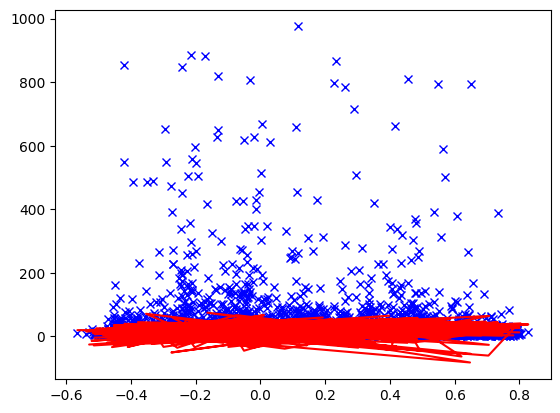

In [436]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_train, 'bx' )
plt.plot ( X_pca, y_train_predicted, 'r' )

##### |Modèle réseaux de neuronnes|
-----------------------------

In [104]:
#Learning rate scheduling function
def schedule ( epoch ):
    if epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [106]:
#Initialisation du model
model_DNN = keras.models.Sequential ( name = 'DNN_predictif_ev_ebitda' )

num_unit1 = 200
num_unit2 = 300
num_unit3 = 300
num_unit4 = 300
num_unit5 = 300
num_unit6 = 300
num_unit7 = 300
num_unit8 = 300
num_unit9 = 200

taux_dropout1 = 0.1
taux_dropout2 = 0.2
taux_dropout3 = 0.2
taux_dropout4 = 0.2
taux_dropout5 = 0.1
taux_dropout6 = 0.1

#Input layer ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Input ( (X_train.shape [1],), name = 'Input_Layer' ) )

#Hidden layer 1 ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit1, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer_1' ) )

#Hidden layer 2------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit2, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer_2' ) )
model_DNN.add ( layers.Dropout ( taux_dropout2 ) )
#Hidden layer 3------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit3, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer_3' ) )
model_DNN.add ( layers.Dropout ( taux_dropout3 ) )
#Hidden layer 4------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit4, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer_4' ) )
model_DNN.add ( layers.Dropout ( taux_dropout4 ) )
#Hidden layer 5------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit5, activation = 'relu', name = 'Hidden_layer_5' ) )
model_DNN.add ( layers.Dropout ( taux_dropout5 ) )
#Hidden layer 6------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit6, activation = 'relu', name = 'Hidden_layer_6' ) )
model_DNN.add ( layers.Dropout ( taux_dropout6 ) )
#Hidden layer 7------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit7, activation = 'relu', name = 'Hidden_layer_7' ) )
model_DNN.add ( layers.Dropout ( taux_dropout6 ) )

#Hidden layer 8------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit8, activation = 'relu', name = 'Hidden_layer_8' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )

#Hidden layer 9------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit9, activation = 'relu', name = 'Hidden_layer_9' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )

#Output layer ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( 1, name = 'Output_layer' ) )

In [107]:
#Caractéristiques du modèle 
model_DNN.compile ( optimizer = 'Adam',
                       loss = 'mse',
                       metrics = ['mae'] )

In [108]:
#Modèle
model_DNN.summary()

Model: "DNN_predictif_ev_ebitda"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_1 (Dense)      (None, 200)               600       
                                                                 
 Hidden_layer_2 (Dense)      (None, 300)               60300     
                                                                 
 dropout_86 (Dropout)        (None, 300)               0         
                                                                 
 Hidden_layer_3 (Dense)      (None, 300)               90300     
                                                                 
 dropout_87 (Dropout)        (None, 300)               0         
                                                                 
 Hidden_layer_4 (Dense)      (None, 300)               90300     
                                                                 
 dropout_88 (Dropout)        (None, 300)   

In [109]:
#Entrainnement du modèle
#callbacks = keras.callbacks.LearningRateScheduler ( schedule ),
hist = model_DNN.fit (X_train, y_train, 
                         epochs = 300,
                         batch_size = 36,  
                         callbacks = keras.callbacks.LearningRateScheduler ( schedule ),                
                         validation_data = (X_validation, y_validation) )

Epoch 1/300
224/224 [==============================] - 9s 31ms/step - loss: 289.7817 - mae: 11.0568 - val_loss: 242.0939 - val_mae: 9.8888 - lr: 1.0000e-04
Epoch 2/300
224/224 [==============================] - 7s 32ms/step - loss: 241.5719 - mae: 10.3371 - val_loss: 241.9302 - val_mae: 9.5770 - lr: 1.0000e-04
Epoch 3/300
224/224 [==============================] - 7s 30ms/step - loss: 240.0107 - mae: 10.3042 - val_loss: 242.3930 - val_mae: 9.4364 - lr: 1.0000e-04
Epoch 4/300
224/224 [==============================] - 7s 31ms/step - loss: 238.2464 - mae: 10.3141 - val_loss: 238.5914 - val_mae: 9.6564 - lr: 1.0000e-04
Epoch 5/300
224/224 [==============================] - 7s 30ms/step - loss: 238.6831 - mae: 10.2935 - val_loss: 236.3280 - val_mae: 9.9315 - lr: 1.0000e-04
Epoch 6/300
224/224 [==============================] - 7s 30ms/step - loss: 236.8484 - mae: 10.2905 - val_loss: 235.6393 - val_mae: 10.2228 - lr: 1.0000e-04
Epoch 7/300
224/224 [==============================] - 7s 30ms/

KeyboardInterrupt: 

In [110]:
loss = pd.DataFrame ( { 'loss' : hist.history['loss'], 'validation_loss' :hist.history ['val_loss'] })
px.line ( loss, x = range (len(loss)), y = ['loss', 'validation_loss'], height = 600, width = 1200 )

##### |Performance du model Réseaux de neuronnes|
--------------------------------------------

In [111]:
#Données d'entrainnement
y_train_predicted = model_DNN.predict ( X_train )
y_train_predicted = y_train_predicted.reshape (y_train.shape)
print ( 'MSE du DNN sur train set =', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du DNN sur train set =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'r2_score du DNN sur train set =', r2_score ( y_train, y_train_predicted ) )

252/252 [==============================] - 4s 15ms/step
MSE du DNN sur train set = 217.3383850403405
MAE du DNN sur train set = 9.954209712987382
r2_score du DNN sur train set = 0.06171791454573117


In [77]:
#Créant une data frame contenant y_test et y_predicted
i = 0
j = 101
y_train_predicted_df = pd.DataFrame ( { 'y_train' : y_train[i:j], 'y_train_predicted' : y_train_predicted[i:j] } )
y_train_predicted_df.reset_index(inplace=True, drop = True )
y_train_predicted_df

#Visualisation de y_test et y_predicted
px.line ( y_train_predicted_df, x = y_train_predicted_df.index, y = ['y_train', 'y_train_predicted'], width  = 900, height = 500 )

In [112]:
#Données test
y_test_predicted = model_DNN.predict ( X_test )
y_test_predicted = y_test_predicted.reshape (y_test.shape)
print ( 'MSE du DNN sur test set =', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du DNN sur test set =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'r2_score du DNN sur test set =', r2_score ( y_test, y_test_predicted ) )

6/6 [==============================] - 0s 17ms/step
MSE du DNN sur test set = 190.87608868723132
MAE du DNN sur test set = 9.480625791496404
r2_score du DNN sur test set = 0.03897375241703249


In [79]:
#Créant une data frame contenant y_test et y_predicted
y_test_predicted_df = pd.DataFrame ( { 'y_test' : y_test, 'y_predicted' : y_test_predicted } )
y_test_predicted_df.reset_index(inplace=True, drop = True )
y_test_predicted_df

#Visualisation de y_test et y_predicted
px.line ( y_test_predicted_df, x = y_test_predicted_df.index, y = ['y_test', 'y_predicted'], width  = 900, height = 500 )

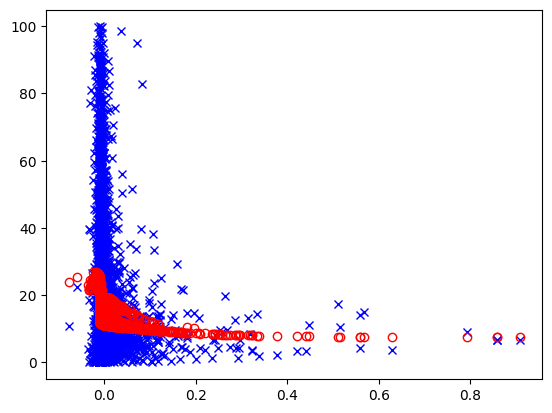

In [82]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
#y_predicted = model_ev_DNN.predict (X_train)

#Visualisation
plt.plot ( X_pca['X1'], y_train,  'bx' )
plt.plot ( X_pca['X1'], y_train_predicted, 'ro', fillstyle = 'none' )
#plt.plot ( X_pca, y_train_predicted, 'r' )

In [55]:
#Performance d'un modèle qui ne predit que la moyenne
mean = np.ones ( y_test.shape )
mean = mean * np.mean ( y_test )

print ( 'MSE du DNN sur test set =', np.mean ( (y_test - mean) ** 2 ))
print ( 'MAE du DNN sur test set =', np.mean ( np.abs(y_test - mean) ) )
print ( 'r2_score du DNN sur test set =', r2_score ( y_test, mean ) )

MSE du DNN sur test set = 198.61693597578102
MAE du DNN sur test set = 9.644289504072907
r2_score du DNN sur test set = 0.0


##### |Gradient Boosting|
------------------------- 

In [117]:
#Search graid
params_grid = { 'max_depth' : [3, 4, 5, 6, 7, 8 , 9]  }
grid_search = GridSearchCV ( GradientBoostingRegressor(), params_grid, cv =5 )
grid_search.fit ( X_train, y_train )

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9]})

In [118]:
grid_search.best_params_

{'max_depth': 3}

In [462]:
#Initialisation du model gradient boosting
model_gradient_boosting = GradientBoostingRegressor ( loss = 'squared_error', learning_rate = 0.1, n_estimators = 300, max_depth = 3 )
model_gradient_boosting 

GradientBoostingRegressor(n_estimators=300)

In [463]:
#Entrainnement du model
model_gradient_boosting.fit ( X_train, y_train )

GradientBoostingRegressor(n_estimators=300)

In [464]:
#performance du model sur les données d'entrainnement 
y_train_predicted = model_gradient_boosting.predict  ( X_train )
print ( 'MSE_train = ', np.mean ( (y_train - y_train_predicted)**2 ) )
print ( 'MAE_train =', np.mean ( np.abs (y_train-y_train_predicted) ) )
print ( 'R2 score_train = ', r2_score ( y_train, y_train_predicted ) )

MSE_train =  854.396407931625
MAE_train = 12.630520136525787
R2 score_train =  0.7518965198157311


In [465]:
#performance du model sur les données test
y_test_predicted = model_gradient_boosting.predict  ( X_test )
print ( 'MSE_test = ', np.mean ( (y_test - y_test_predicted)**2 ) )
print ( 'MAE_test =', np.mean ( np.abs (y_test-y_test_predicted) ) )
print ( 'R2 score_test = ', r2_score ( y_test, y_test_predicted ) )

MSE_test =  3464.1253259353225
MAE_test = 17.882444536592338
R2 score_test =  0.10051649552488973


In [131]:
#Créant une data frame contenant y_test et y_predicted
y_test_predicted_df = pd.DataFrame ( { 'y_test' : y_test, 'y_predicted' : y_test_predicted } )
y_test_predicted_df.reset_index(inplace=True, drop = True )
y_test_predicted_df

#Visualisation de y_test et y_predicted
px.line ( y_test_predicted_df, x = y_test_predicted_df.index, y = ['y_test', 'y_predicted'], width  = 900, height = 500 )

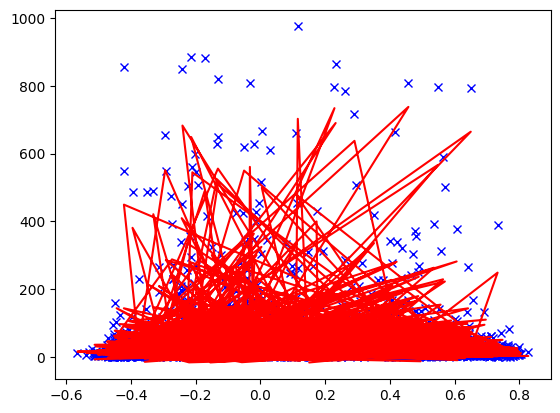

In [466]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_train, 'bx' )
plt.plot ( X_pca, y_train_predicted, 'r' )

##### Random Forest

In [313]:
#Initialization et entrainnement du model
model_random_forest = RandomForestRegressor (criterion = 'squared_error', n_estimators = 60)
model_random_forest.fit (X_train, y_train)

RandomForestRegressor(n_estimators=60)

In [314]:
#performance du model sur les données d'entrainnement 
y_train_predicted = model_random_forest.predict  ( X_train )
print ( 'MSE_train = ', np.mean ( (y_train - y_train_predicted)**2 ) )
print ( 'MAE_train =', np.mean ( np.abs (y_train-y_train_predicted) ) )
print ( 'R2 score_train = ', r2_score ( y_train, y_train_predicted ) )

MSE_train =  456.1169895965225
MAE_train = 7.410442467532468
R2 score_train =  0.8783982031215403


In [315]:
#performance du model sur les données test
y_test_predicted = model_random_forest.predict  ( X_test )
print ( 'MSE_test = ', np.mean ( (y_test - y_test_predicted)**2 ) )
print ( 'MAE_test =', np.mean ( np.abs (y_test-y_test_predicted) ) )
print ( 'R2 score_test = ', r2_score ( y_test, y_test_predicted ) )

MSE_test =  753.7631837319822
MAE_test = 15.01715045045045
R2 score_test =  0.24078998766206172


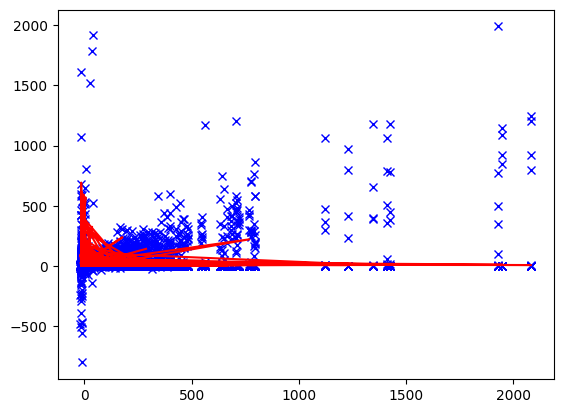

In [316]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, X_train, 'bx' )
plt.plot ( X_pca, y_train_predicted, 'r' )

#### **EV/EBIT**

##### X train y train X test y test
-----------------------------

In [ ]:
#Ajoutons la colonne ev/ebitda last a data labels
data_ev_ebit = pd.merge ( data_labels, entreprise_values['EV/Sales - Last'], right_index = True, left_index = True )

#Supprimons les valeurs nulles de data_ev_ebitda
data_ev_ebit = data_ev_ebit.dropna ()

#Suppression des valeurs N/M
index = data_ev_ebit [data_ev_ebit [ 'EV/Sales - Last' ] == 'N/M'].index
data_ev_ebit = data_ev_ebit.drop ( index )

#Changeons le type de la colonne EV/EBITDA en float
data_ev_ebit ['EV/Sales - Last'] = data_ev_ebit ['EV/Sales - Last'].astype (float)
data_ev_ebit

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy,labels,EV/Sales - Last
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,0,0,0,0,0,0,0,0,4,0.30
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,0,0,0,0,0,0,0,0,4,7.72
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,0,0,0,0,0,0,0,0,4,0.33
39,30156KN,BOC Gases Plc,Medical Equipment,NGA,0.517857,0.238806,-0.986301,-0.183777,0.431579,-0.046201,...,0,0,0,0,0,0,0,0,4,0.28
43,30046KN,Berger Paints Nigeria PLC,Specialty Chemicals,NGA,0.517857,0.701493,-0.287671,-0.167278,0.335526,0.713992,...,0,0,0,0,0,0,0,0,4,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,30112AN,Marsden Maritime Holdings Limited,Transportation Services,NZL,0.571429,0.820896,0.178082,-0.194703,0.453947,-0.951892,...,0,0,0,0,0,0,0,0,7,28.66
83674,40025AN,Metro Performance Glass Ltd.,Building Materials & Fixtures,NZL,0.571429,-0.611940,0.753425,0.324948,-0.481579,0.256527,...,0,0,0,0,0,0,0,0,4,0.36
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,0,0,0,0,0,0,0,0,7,1.94
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0,0,0,0,0,0,0,0,4,0.34


In [ ]:
#Ajoutons 'EV/EBITDA - Last' à colonnes principales
colonnes_principales_EV_ebit = colonnes_principales + ['EV/Sales - Last']
data_ev_ebit [colonnes_principales_EV_ebit]

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/Sales - Last
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620,4,0.30
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129,4,7.72
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069,4,0.33
39,30156KN,BOC Gases Plc,Medical Equipment,NGA,0.517857,0.238806,-0.986301,-0.183777,0.431579,-0.046201,...,0.211401,-0.089054,-0.180334,-0.173655,0.933293,1.031295,0.457732,1.494179,4,0.28
43,30046KN,Berger Paints Nigeria PLC,Specialty Chemicals,NGA,0.517857,0.701493,-0.287671,-0.167278,0.335526,0.713992,...,2.861045,-0.123795,-0.186725,-0.174297,0.066707,0.088064,0.169072,0.352736,4,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83668,30112AN,Marsden Maritime Holdings Limited,Transportation Services,NZL,0.571429,0.820896,0.178082,-0.194703,0.453947,-0.951892,...,6.194774,-0.002579,0.047649,0.222528,6.644027,7.743086,0.088660,1.518626,7,28.66
83674,40025AN,Metro Performance Glass Ltd.,Building Materials & Fixtures,NZL,0.571429,-0.611940,0.753425,0.324948,-0.481579,0.256527,...,1.237530,0.241785,0.178698,0.040507,-0.048514,-0.326055,-0.519588,-0.366705,4,0.36
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537,7,1.94
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333,4,0.34


In [ ]:
#Melange de la dataset
data_shuffled = data_ev_ebit[colonnes_principales_EV_ebit].sample ( frac = 1, random_state = 42 )
data_shuffled

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,labels,EV/Sales - Last
55034,31069PC,"Dong-E-E-Jiao Co., Ltd.",Pharmaceuticals,CHN,-0.392857,0.417910,-0.520548,1.740758,0.055263,-0.539014,...,-0.472684,3.719694,3.568732,5.999767,0.969679,1.170306,0.045361,0.769499,5,8.33
71129,31278EI,Arterra Bioscience SpA,Biotechnology,ITA,0.089286,-0.671642,-0.767123,-0.198294,0.875000,-0.531241,...,0.015439,-0.102787,-0.183096,-0.158864,3.312310,3.196507,0.492784,2.761350,7,2.67
49097,40347PC,Hytera Communications Corp. Ltd.,Telecommunications Equipment,CHN,-0.392857,0.761194,0.616438,2.693655,-1.098684,-0.378117,...,0.618765,3.499832,3.233060,3.520600,0.440267,0.187045,-0.008247,-0.144354,5,2.73
67307,33081FI,Cosco (India) Limited,Recreational Products,IND,0.000000,0.537313,1.369863,-0.153836,-0.222368,0.800528,...,-0.117577,-0.138645,-0.181053,-0.180288,-0.302608,-0.144105,-0.187629,-0.111758,3,0.81
52155,31151PC,"Guangxi Wuzhou Communications Co., Ltd.",Transportation Services,CHN,-0.392857,0.820896,0.821918,0.683436,0.460526,-0.751393,...,-0.402613,3.112330,2.722821,3.178033,2.879321,2.833333,0.251546,0.198487,7,4.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59931,40008OE,Ekspress Grupp AS,Publishing,EST,-0.196429,0.477612,0.356164,0.012900,0.090789,-0.073335,...,0.185273,0.072632,0.009764,0.040603,0.190418,0.072780,0.027491,-0.143190,4,1.05
55001,30677PC,"China Animal Husbandry Industry Co., Ltd.",Pharmaceuticals,CHN,-0.392857,0.417910,-0.301370,2.477342,0.494737,0.010707,...,-0.406176,3.075433,2.164184,2.976072,0.273499,0.308588,0.258419,0.108265,5,2.93
56220,40009PC,"New Huadu Supercenter Co., Ltd.",Food Retailers & Wholesalers,CHN,-0.392857,-0.149254,1.767123,2.179036,-0.402632,0.468172,...,0.631829,0.669294,0.589298,0.676781,-0.167374,-0.238719,0.631615,-0.130384,4,1.30
6396,30076FN,Hong Leong Asia Ltd.,Building Materials & Fixtures,SGP,0.821429,-0.611940,-0.136986,9.293935,-0.331579,0.055148,...,-0.298100,5.029761,7.975303,7.086428,-0.217101,-0.244541,-0.329210,-0.209546,13,0.48


In [ ]:
#Calcule des corrélations
correlations = data_shuffled.drop (  ['Efcode', 'Company Name', 'Sector_Original', 'Country_Original'], axis = 1 ).corr()['EV/Sales - Last'] 
correlations.abs().sort_values(ascending = False)

EV/Sales - Last                    1.000000
EBITDA Marg. (%) - Last            0.113032
Sales To Assets (%) - Last         0.110769
EBIT Marg. (%) - Last              0.095294
ROCE (%) - Last                    0.055935
Country                            0.053569
labels                             0.044941
ROE (%) - Last                     0.042055
ROA - Last                         0.033522
Fin. Debt / Equity (%) - 2020      0.018466
Sector                             0.017867
Net Sales - Last                   0.016108
Sales To Receiv. - Last            0.010618
Fin. Debt / Assets (%) - Last.1    0.007376
Sales To Assets (%) - Last.1       0.007166
Fin. Debt / Assets (%) - 2020.1    0.006319
Fin. Debt / Assets (%) - 2020      0.006047
Days in Inventory - Last           0.004848
Goodwill / Equity (%) - Last       0.003632
Fin. Debt / Assets (%) - Last      0.003484
EBITDA - Last                      0.003084
Net Debt / Equity (x) - Last.1     0.002819
Total Assets - Last             

In [ ]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
X = data_shuffled.drop (  ['Efcode', 'Company Name', 'Sector_Original', 'Country_Original', 'EV/Sales - Last'], axis = 1 )

#YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY
y = data_shuffled ['EV/Sales - Last']
y

55034    8.33
71129    2.67
49097    2.73
67307    0.81
52155    4.47
         ... 
59931    1.05
55001    2.93
56220    1.30
6396     0.48
67614    0.52
Name: EV/Sales - Last, Length: 10238, dtype: float64

In [163]:
#X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y, stratify = X.labels, train_size = 0.98 )
X_train,  X_validation, y_train, y_validation = train_test_split ( X_train, y_train, train_size = 0.98 )
print ( 'X_train size :', X_train.shape )
print ( 'y_train size :', y_train.shape )
print ( 'X_validation size :', X_validation.shape )
print ( 'y_validation size :', y_validation.shape )
print ( 'X_test size :', X_test.shape )
print ( 'y_test size :', y_test.shape )

X_train size : (9832, 30)
y_train size : (9832,)
X_validation size : (201, 30)
y_validation size : (201,)
X_test size : (205, 30)
y_test size : (205,)


In [165]:
#Les classes dans la data test
X_test.labels.value_counts()

4     45
0     34
2     21
13    20
5     18
3     15
12    11
9     11
7      9
1      8
6      8
8      5
Name: labels, dtype: int64

##### |Model LinearRegression|
-----------------------------

In [166]:
# Model linear regression
model_linear_regression = LinearRegression ()

In [168]:
model_linear_regression.fit ( X_train, y_train )
model_linear_regression

LinearRegression()

|Performance du model|
-----------------------------

In [169]:
#R2score data d'entrainnement
y_train_predicted = model_linear_regression.predict ( X_train )

print ('MSE du model LinearRegression = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_train, y_train_predicted ) )

MSE du model LinearRegression =  418.0876861098291
MAE du model LinearRegression = 4.724826775533676
R2 score du model LinearRegression =  0.030580576077784638


In [170]:
#R2score data test
y_predicted = model_linear_regression.predict ( X_test )

print ('MSE du model LinearRegression = ', np.mean ( (y_test - y_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_test - y_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_test, y_predicted ) )

MSE du model LinearRegression =  1139.743970463815
MAE du model LinearRegression = 6.843174932062377
R2 score du model LinearRegression =  -0.00690274730583651


In [171]:
#Créant une data frame contenant y_test et y_predicted
y_test_predicted = pd.DataFrame ( { 'y_test' : y_test, 'y_predicted' : y_predicted } )
y_test_predicted.reset_index(inplace=True, drop = True )
y_test_predicted

#Visualisation de y_test et y_predicted
px.line ( y_test_predicted, x = y_test_predicted.index, y = ['y_test', 'y_predicted'], width  = 900, height = 500 )


##### |**Modèle réseaux de neuronnes**|
-----------------------------

In [172]:
#Learning rate scheduling function
def schedule ( epoch ):
    if epoch < 200:
        return 0.01
    else :
        return 0.001

In [174]:
#Initialisation du modèle 
num_unit1 = 100
num_unit2 = 100
num_unit3 = 100
num_unit4 = 100
taux_dropout_1 = 0.1
taux_dropout_2 = 0.1
taux_dropout_3 = 0.1

model_ev_DNN = keras.models.Sequential ( name = 'EV_Neural_Network' )
#Input layer
model_ev_DNN.add ( layers.Input ( (X_train.shape [1],) , name = 'Input_layer' ) )
#hidden layer 1
#model_ev_DNN.add ( layers.Dropout ( taux_dropout_1 ) )
model_ev_DNN.add ( layers.Dense ( num_unit1, activation = 'sigmoid', name = 'Hidden_layer_1' ) )
#hidden layer 2
#model_ev_DNN.add ( layers.Dropout ( taux_dropout_2 ) )
model_ev_DNN.add ( layers.Dense ( num_unit2, activation = 'sigmoid', name = 'Hidden_layer_2' ) )
#hidden layer 3
#model_ev_DNN.add ( layers.Dropout ( taux_dropout_3 ) )
model_ev_DNN.add ( layers.Dense ( num_unit3, activation = 'sigmoid', name = 'Hidden_layer_3' ) )
#hidden layer 4
#model_ev_DNN.add ( layers.Dropout ( taux_dropout_3 ) )
model_ev_DNN.add ( layers.Dense ( num_unit4, activation = 'sigmoid', name = 'Hidden_layer_4' ) )
#Output layer
model_ev_DNN.add ( layers.Dense ( 1, name = 'Output_layer' ) )

In [175]:
#Caractéristiques du modèle 
model_ev_DNN.compile ( optimizer = 'adam',
                       loss = 'mse',
                       metrics = ['mae'] )

In [176]:
#Modèle
model_ev_DNN.summary()

Model: "EV_Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_1 (Dense)      (None, 100)               3100      
                                                                 
 Hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_4 (Dense)      (None, 100)               10100     
                                                                 
 Output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 33,501
Trainable params: 33,501
Non-trainable params: 0
_________________________________________________________________


In [177]:
#Entrainnement du modèle
hist = model_ev_DNN.fit (X_train, y_train, 
                         epochs = 300,
                         batch_size = 64,
                         validation_data = (X_validation, y_validation) )

Epoch 1/300
154/154 [==============================] - 2s 5ms/step - loss: 432.5596 - mae: 4.6780 - val_loss: 1046.6530 - val_mae: 6.6300
Epoch 2/300
154/154 [==============================] - 1s 4ms/step - loss: 429.5644 - mae: 4.6932 - val_loss: 1047.6628 - val_mae: 6.3039
Epoch 3/300
154/154 [==============================] - 1s 3ms/step - loss: 423.5774 - mae: 4.2673 - val_loss: 1047.9985 - val_mae: 5.7966
Epoch 4/300
154/154 [==============================] - 1s 4ms/step - loss: 419.0335 - mae: 3.9879 - val_loss: 1027.7850 - val_mae: 6.1118
Epoch 5/300
154/154 [==============================] - 1s 4ms/step - loss: 415.3589 - mae: 3.9117 - val_loss: 1017.6773 - val_mae: 6.3793
Epoch 6/300
154/154 [==============================] - 1s 4ms/step - loss: 412.4695 - mae: 3.9176 - val_loss: 1006.8037 - val_mae: 5.9865
Epoch 7/300
154/154 [==============================] - 1s 4ms/step - loss: 410.3895 - mae: 3.8427 - val_loss: 1006.0129 - val_mae: 6.8453
Epoch 8/300
154/154 [=============

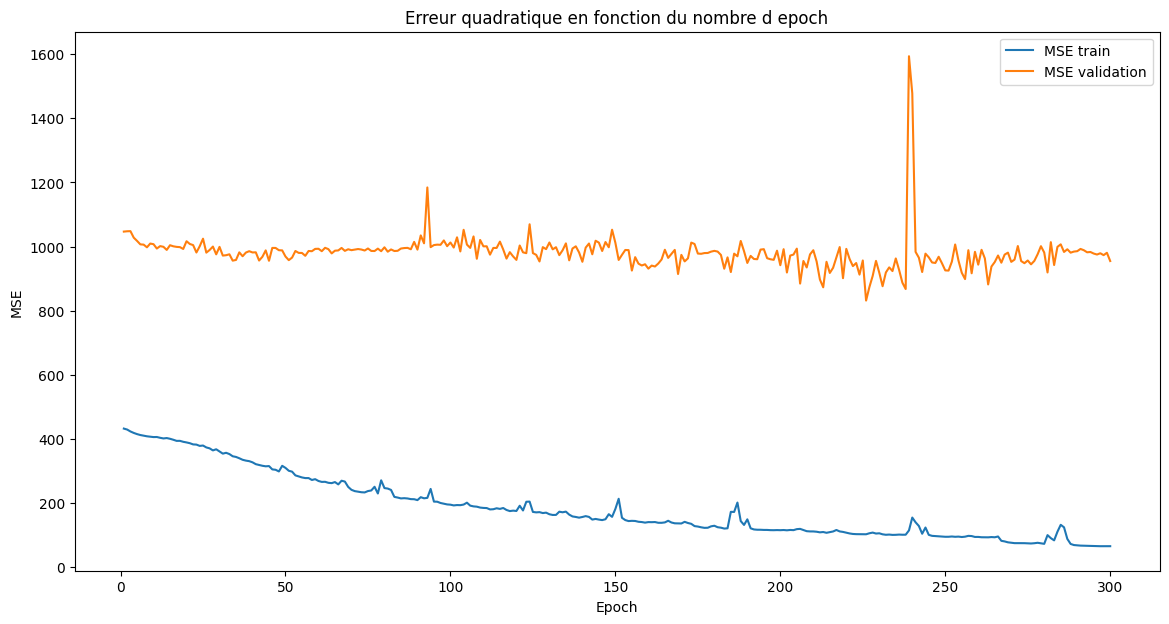

In [178]:
#Visualisation de l'érreur quadratique en fonction du nombre d'epoch
figure = plt.gcf()
figure.set_size_inches((14, 7))
plt.title('Erreur quadratique en fonction du nombre d epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(range(1, len(hist.history['loss']) + 1), hist.history['loss'])
plt.plot(range(1, len(hist.history['val_loss']) + 1), hist.history['val_loss'])
plt.legend(['MSE train', 'MSE validation'])
plt.show()

##### |Performance du model Réseaux de neuronnes|
--------------------------------------------

In [179]:
#Données d'entrainnement
y_train_predicted = model_ev_DNN.predict ( X_train )
y_train_predicted = y_train_predicted.reshape (y_train.shape)
print ( 'MSE du DNN sur train set =', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du DNN sur train set =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'r2_score du DNN sur train set =', r2_score ( y_train, y_train_predicted ) )

308/308 [==============================] - 1s 2ms/step
MSE du DNN sur train set = 64.72507999984258
MAE du DNN sur train set = 1.9465459510036558
r2_score du DNN sur train set = 0.8499220334600246


In [181]:
#Créant une data frame contenant y_test et y_predicted
i = 0
j = 101
y_train_predicted_df = pd.DataFrame ( { 'y_train' : y_train[i:j], 'y_train_predicted' : y_train_predicted[i:j] } )
y_train_predicted_df.reset_index(inplace=True, drop = True )
y_train_predicted_df

#Visualisation de y_test et y_predicted
px.line ( y_train_predicted_df, x = y_train_predicted_df.index, y = ['y_train', 'y_train_predicted'], width  = 900, height = 500 )

In [182]:
#Données test
y_test_predicted = model_ev_DNN.predict ( X_test )
y_test_predicted = y_test_predicted.reshape (y_test.shape)
print ( 'MSE du DNN sur test set =', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du DNN sur test set =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'r2_score du DNN sur test set =', r2_score ( y_test, y_test_predicted ) )

7/7 [==============================] - 0s 2ms/step
MSE du DNN sur test set = 1338.8235835552173
MAE du DNN sur test set = 6.849939548492432
r2_score du DNN sur test set = -0.18277892173538146


In [183]:
#Créant une data frame contenant y_test et y_predicted
y_test_predicted_df = pd.DataFrame ( { 'y_test' : y_test, 'y_predicted' : y_test_predicted } )
y_test_predicted_df.reset_index(inplace=True, drop = True )
y_test_predicted_df

#Visualisation de y_test et y_predicted
px.line ( y_test_predicted_df, x = y_test_predicted_df.index, y = ['y_test', 'y_predicted'], width  = 900, height = 500 )

In [ ]:
#Prediction de quelques valeurs
i = 55
X_train[i : i+1]
print ('valeur réele =', y_train[i : i+1].values)
print ('valeur prédit = ', model_ev_DNN.predict (X_train[i : i+1]))

valeur réele = [148.46]
1/1 [==============================] - 0s 43ms/step
valeur prédit =  [[148.75851]]


In [ ]:
#Prediction de quelques valeurs
i = 55
X_test[i : i+1]
print ('valeur réele =', y_test[i : i+1].values)
print ('valeur prédit = ', model_ev_DNN.predict (X_test[i : i+1]))

valeur réele = [33.52]
1/1 [==============================] - 0s 39ms/step
valeur prédit =  [[23.849493]]
